# 2D Gan Experiments

## Create 2D Datasets

2D data is easy to anayze, because we can plot an arbitray large batch of a distribution at once, which is not possible for image data - you can only plot one image at a time.

We want to have a dataset with a few modes - we chose 4. Therefore we sample from a Gaussian Mixture that has centers the centers $\{(-1, -1), (-1, 1), (1, -1), (1, 1)\}$.
A Gaussian mixture has connected support - the pdf is greater than zero everywhere (although small far away from the centers). We are also interested in learning distributions with unconnected support, such as images of faces with and without glasses. So we change the distribution and reject all samples that have a distance larger than 0.2 from their respective  centers.

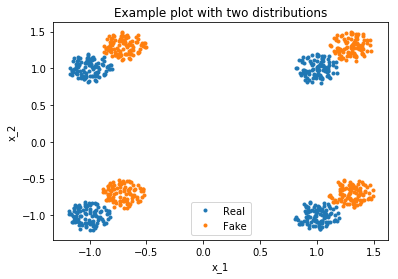

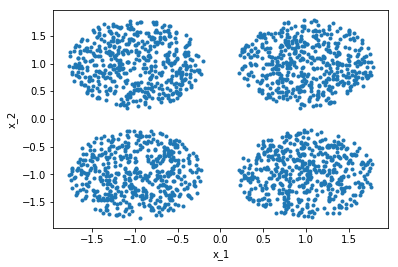

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

na = None

def show_2d(x_real, x_fake=None, title=None, space='x'):
    plt.plot(x_real[:, 0], x_real[:, 1], '.', label='Real')
    if x_fake is not None:
        plt.plot(x_fake[:, 0], x_fake[:, 1], '.', label='Fake')
        plt.legend()
    if title is not None:
        plt.title(title)
    plt.xlabel(space+'_1')
    plt.ylabel(space+'_2')
    plt.show()

    

def get_mode(center, n_per_mode, r):
    samples = np.random.normal(center, r, size=(3*n_per_mode, 2))
    dist = np.linalg.norm(samples-center[na,...], axis=1)
    return samples[dist<r][:n_per_mode]

def generate_2d(n_per_mode, radius=0.2):
    centers = [
        np.array([-1, -1]),
        np.array([-1, 1]),
        np.array([1, -1]),
        np.array([1, 1])
    ]
    return np.concatenate([get_mode(c, n_per_mode, radius) for c in centers], axis=0)

x = generate_2d(100)
show_2d(x, x+0.3, 'Example plot with two distributions')
show_2d(generate_2d(500, 0.8))

In [2]:
# Now we create the one and only version of thsi dataset that we are going to use for all experiments
# don't execute again, it overwrites the saved data
# np.save('data/2d.npy', generate_2d(500))

The dataset can be loaded now:

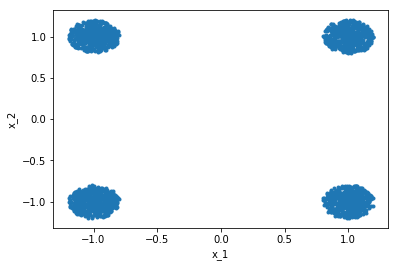

(2000, 2)

In [3]:
x = np.load('data/2d.npy')
show_2d(x)
x.shape

## D and G architecture

We have the data, now let's create a generator and a discriminator. We will experiment with different architectures and we often want to use a symmetric architecture for D and G, so let's build it modular such that the hidden layers will be passed as argument.

In [4]:
import keras
from keras import layers
from keras.models import Model
import time
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


In [53]:
class Subnet():
    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __call__(self, *args, **kwargs):
        return self.model.predict(*args, **kwargs)

mini_arch = lambda: [
    layers.Dense(4, use_bias=False, input_shape=(2,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(4, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU()
]

big_arch = lambda: [
    layers.Dense(100, use_bias=False, input_shape=(2,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dense(100, use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU()
]

def flexibel_arch(neurons):
    return lambda: [
        layers.Dense(neurons, use_bias=False, input_shape=(2,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(neurons, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU()
    ]
    


class Discriminator(Subnet):
    def __init__(self, hidden_layers):
        # 2 hidden layers a 4 neurons, random init, batchnorm
        inputs=keras.Input(shape=[2])
        self.layers = hidden_layers() + [layers.Dense(1, activation='sigmoid')]
        self.model = Model(inputs=inputs, outputs=self.forward(inputs))
        self.optimizer = keras.optimizers.Adam(0.0002, 0.5)
        
        
class Generator(Subnet):
    def __init__(self, hidden_layers, outputlayer=lambda: layers.Dense(2)):
        # 2 hidden layers a 4 neurons, random init, batchnorm
        inputs=keras.Input(shape=[2])
        self.layers = hidden_layers() + [outputlayer()]
        self.model = Model(inputs=inputs, outputs=self.forward(inputs))
        self.optimizer = keras.optimizers.Adam(0.0002, 0.5)
        
    def loss(self, D):
        # D: keras model
        def l(y_target, x_fake):
            # y_target: always 1
            y_fake = D(x_fake)
            return keras.losses.binary_crossentropy(y_target, y_fake)
        return l
    

D = Discriminator(mini_arch)
G = Generator(mini_arch)

## Training Analysis and Callbacks

Now let's train a GAN to sample from this distribution. We can analyze the training by repeatedly checking the following questions:
1. how does the learned distribution change over time?
2. what is $ D(G(z)) $ for a grid of $z$s?
3. what is the mapping $G$? We can associate each point $z$ with a color $C(G(z))$, where the color mapping $C$ is e.g. an rgb color: $(x_1, x_2) -> rgb(n(x_1), n(x_2), 0) $ where $n$ is an affine function.

Let's create the plot functions we can use to analyze our GAN one by one. During training, we can pass it as callbacks that are executed after each epoch, to see how training evolves.


### Show the learned distribution

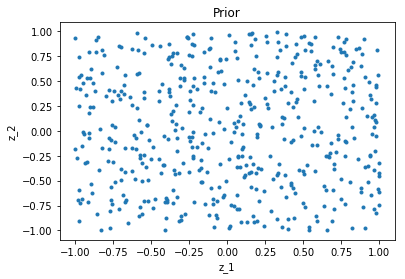

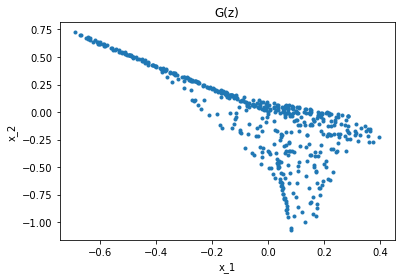

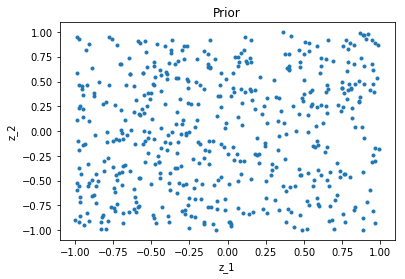

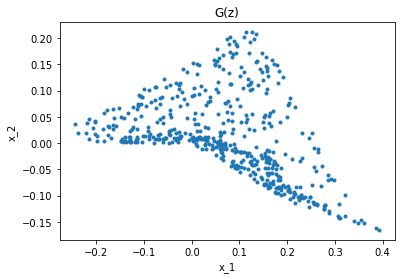

In [41]:
class Uniform():
    def __init__(self, d=2):
        self.d = d
    
    def __call__(self, n):
        return np.random.uniform(low=-1, high=1, size=(n, self.d))

uniform = Uniform()

def show_learned_distribution(prior, G):
    z = prior(500)
    show_2d(z, title='Prior', space='z')
    show_2d(G(z), title='G(z)')

show_learned_distribution(uniform, G)
show_learned_distribution(uniform, Generator(big_arch))


### Showing the mapping of G with a colorful plot

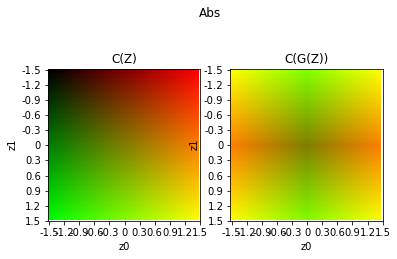

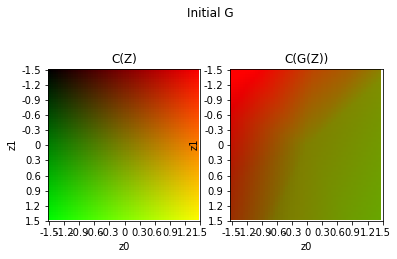

In [8]:
def make_grid():
    ticks = np.arange(-1.5, 1.5, 0.05)
    return np.dstack(np.meshgrid(ticks, ticks)).reshape(-1, 2)

def grid_labels():
    return range(0, 61, 6), [f"{i/50:.2g}" for i in range(-75, 76, 15)] 

grid = make_grid()

def colors_of(x):
    c = np.zeros([x.shape[0], 3])
    c[:, :2] = (x+1.5)/3
    return np.clip(c, 0, 1)

def color_plot(mapping, title=None):
    z = make_grid()
    x = mapping(z)
    
    fig, ax = plt.subplots(ncols=2)
    
    ax[0].imshow(colors_of(z).reshape(60, 60, 3))
    ax[0].set_title('C(Z)')
    ticks, labels = grid_labels()
    ax[0].set_xticks(ticks)
    ax[0].set_xticklabels(labels)
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(labels)
    ax[0].set_xlabel('z0')
    ax[0].set_ylabel('z1')
    
    ax[1].imshow(colors_of(x).reshape(60, 60, 3))
    ax[1].set_title('C(G(Z))')
    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels)
    ax[1].set_yticks(ticks)
    ax[1].set_yticklabels(labels)
    ax[1].set_xlabel('z0')
    ax[1].set_ylabel('z1')
    
    if title is not None:
        fig.suptitle(title)
    
    plt.show()
    
color_plot(lambda x: np.abs(x), 'Abs')
color_plot(G, 'Initial G')
    
    

### Plot $D(G(z))$ over a grid of $z$s

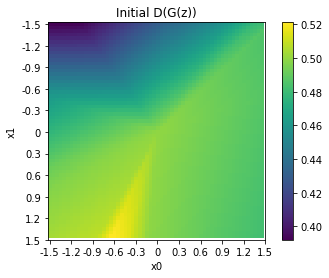

In [9]:
def score_over_z(G, D, title=None):
    z = make_grid()
    dgz = D(G(z))
    plt.imshow(dgz.reshape(60, 60))
    ticks, labels = grid_labels()
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
score_over_z(G, D, "Initial D(G(z))")

## GAN Training

We have everything prepared, now we can train our GAN. We want to keep it modular with respect to the `Generator` and `Discriminator` class as well as the `prior` function, so that we can use it on another dataset like MNIST as well, or test different priors.

### The GAN

In [11]:
def batches(x, batch_size):
    """
    :x: shape (N, d)
    :return: Yields batches
    """
    x = x[np.random.permutation(len(x))][:int(len(x)/batch_size)*batch_size]
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size]
        
        
class GAN():
    def __init__(self, prior, G, D):
        self.prior = prior
        
        D_loss = keras.losses.binary_crossentropy
        D.model.compile(D.optimizer, D_loss)
        self.D = D
        
        D.model.trainable = False # D is already compiled, this will only effect the Generator loss
        g_loss = G.loss(D.model)
        G.model.compile(G.optimizer, g_loss)
        self.G = G
        
    def get_mixed_batch(self, x_real):
        n = x_real.shape[0]
        z = self.prior(n)
        x_fake = self.G(z)
        x_mix = np.concatenate([x_fake, x_real], axis=0)
        y_target = np.concatenate([np.zeros(n), np.ones(n)], axis=0)
        return x_mix, y_target
        
    def train_step(self, x_real, g_updates, d_updates):
        n = x_real.shape[0]
        
        test_y = self.D(x_real)
        for _ in range(g_updates):
            z = self.prior(n)
            self.G.model.train_on_batch(z, np.ones(n))
        assert (self.D(x_real) == test_y).all(), "Generator update effects D"
        
        z = self.prior(n)
        test_fakes = self.G(z)
        for _ in range(d_updates):
            x_mix, y_target = self.get_mixed_batch(x_real)
            self.D.model.train_on_batch(x_mix, y_target)
        assert (self.G(z) == test_fakes).all(), "Discriminator update effects G"

    def fit(self, x, epochs, file_prefix, callbacks=[], g_updates=1, d_updates=1):
        """
        x: samples from the real distribution
        epochs: how many epochs to train
        file_prefix: saves the model to ./models/file_prefix<_g.npy and _d.npy>
        callbacks: [(f(z_at_epoch), num_epochs), ...] to execute every num_epochs
        g_updates: int, so many generator updates happen per train step
        d_updates: int, so many discriminator updates happen per train step
        returns: z_at_epoch: [G_at_epoch_i(fixed_z)) for i in range(epochs)]
        """
        for epoch in range(epochs):
            start = time.time()

            for x_real in batches(x, 128):
                self.train_step(x_real, g_updates, d_updates)
            print('.', end='')
            
            for callback, rhythm in callbacks:
                if (epoch+1) % rhythm == 0:
                    callback()
            #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    def save(self, file_prefix):
        self.G.model.save(f"{file_prefix}_g.h5")
        self.D.model.save(f"{file_prefix}_d.h5")
    
    @staticmethod
    def load(file_prefix, prior):
        G = load_model(f"{file_prefix}_g.h5")
        D = load_model(f"{file_prefix}_d.h5")
        return GAN(prior, G, D)
    
gan = GAN(uniform, Generator(), Discriminator())
print(gan.G.model.summary())
print(gan.D.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 8         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4)                 16        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 16        
_________________________________________________________________
batch_normalization_6 (Batch (None, 4)                 16        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4)                 0         
__________

/Users/P378593/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


### More callbacks

We will define a few more callbacks that track and plot loss or accuracy, and one that shows how the projection of a batch of fixed $z$s evolves during training

In [86]:
class EvolvingCallback():
    def __init__(self, gan):
        self.gan = gan
        self.z = gan.prior(100) # for plotting how the projection evolves
        self.z_at_epoch = [gan.G(self.z)]
    
    def track(self):
        self.z_at_epoch += [self.gan.G(self.z)]
        
    def plot(self):
        t = np.stack(self.z_at_epoch, axis=0)
        epochs = len(self.z_at_epoch)
        plt.clf()
        plt.plot(x[:,0], x[:,1], 'o')
        for p in range(t.shape[1]):
            plt.plot(t[:,p,0], t[:,p,1], alpha=0.5, color='orange')
        plt.plot(t[-1,:,0], t[-1,:,1], 'o', color='red')
        plt.title(f"Epoch {epochs}")
        plt.show()

        
class LossMetrics():
    def __init__(self, gan, x_test):
        self.gan = gan
        self.x_test = x_test
        self.z_test = gan.prior(len(x_test))
        self.g_losses = []
        self.d_losses = []
        self.d_loss_real = []
        self.d_loss_fake = []
        
    def track(self, *ignored_args, **ignored_kwargs):
        x_mix, y_target = gan.get_mixed_batch(self.x_test)
        self.g_losses.append(self.gan.G.model.evaluate(self.z_test, np.ones(len(self.z_test)), verbose=0))
        self.d_losses.append(self.gan.D.model.evaluate(x_mix, y_target, verbose=0))
        self.d_loss_real.append(self.gan.D.model.evaluate(self.x_test, np.ones(len(x)), verbose=0))
        self.d_loss_fake.append(self.gan.D.model.evaluate(self.gan.G(self.z_test), np.zeros(len(self.z_test)), verbose=0))
    
    def plot(self, *ignored_args, **ignored_kwargs):    
        plt.plot(self.g_losses, label='G')
        plt.plot(self.d_losses, label='D')
        plt.plot(self.d_loss_real, label='D(real)')
        plt.plot(self.d_loss_fake, label='D(fake)')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        
        
class PMetrics():
    def __init__(self, gan, x_test):
        self.gan = gan
        self.x_test = x_test
        self.z_test = gan.prior(len(x_test))
        self.p_fake, self.fake_std = [], []
        self.p_real, self.real_std = [], []
        
    def track(self, *ignored_args, **ignored_kwargs):
        y_fake = self.gan.D(self.gan.G(self.z_test))
        y_real = self.gan.D(self.x_test)
        self.p_fake += [y_fake.mean()]
        self.p_real += [y_real.mean()]
        self.fake_std += [y_fake.std()]
        self.real_std += [y_real.std()]
        
    def plot(self, *ignored_args, **ignored_kwargs):
        epochs = range(len(self.p_fake))
        plt.errorbar(epochs, self.p_fake, self.fake_std, label='D(G(z))', color='blue')
        #plt.plot(epochs, np.array(self.p_fake) + np.array(self.fake_std), '--', color='blue')
        #plt.plot(epochs, np.array(self.p_fake) - np.array(self.fake_std), '--', color='blue')
        plt.errorbar(epochs, self.p_real, self.real_std, label='D(x)', color='orange', alpha=0.75)
        #plt.plot(epochs, np.array(self.p_real) + np.array(self.real_std), '--', color='orange')
        #plt.plot(epochs, np.array(self.p_real) - np.array(self.real_std), '--', color='orange')
        plt.title('P(real)')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()


def d_landscape(d, title=None):
    x = make_grid()
    dgz = d(x)
    plt.imshow(dgz.reshape(60, 60))
    ticks, labels = grid_labels()
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()


class DLandscapeCallback():
    def __init__(self, gan):
        self.D = gan.D
    
    def plot(self, *args, **kwargs):
        d_landscape(self.D)
 

## Experiments
Now we can do experiments.



### Initial Experiments: can G fit a fixed D, vice verca and can both fit our toy data
Let's start with the following three:
- train only G and see that it gets better at fooling D
- train only D and see that it gets better at recognizing fakes and trues
- train G and D and see if it learns our real distribution

Train only G


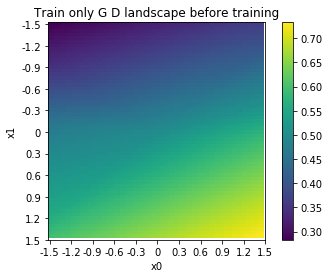

..................................................

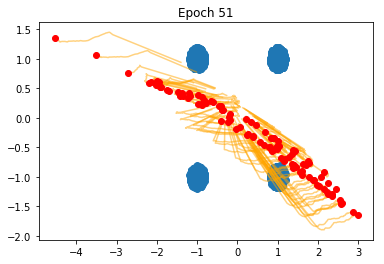

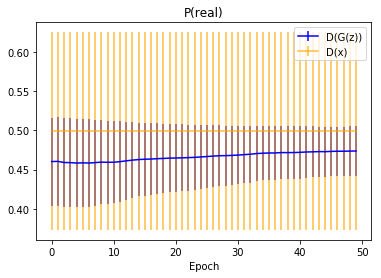

..................................................

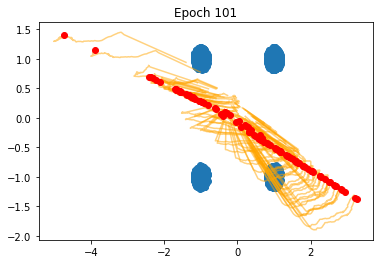

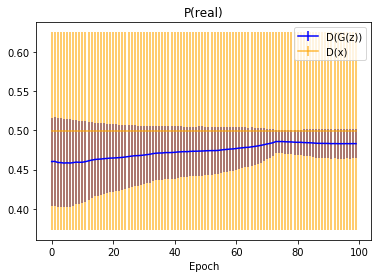

..................................................

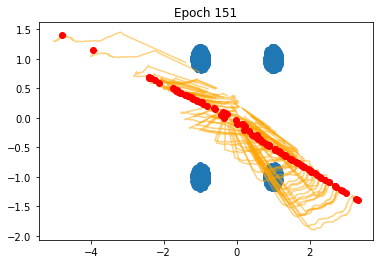

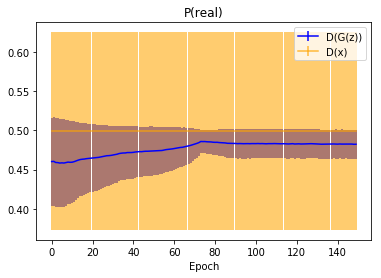

..................................................

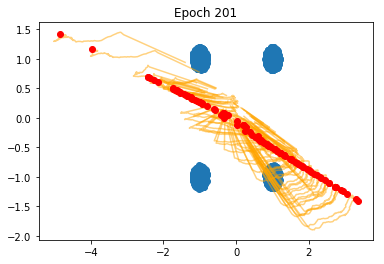

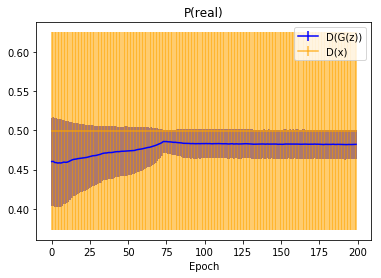

..................................................

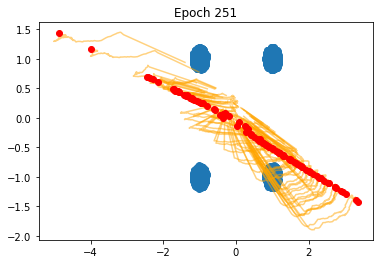

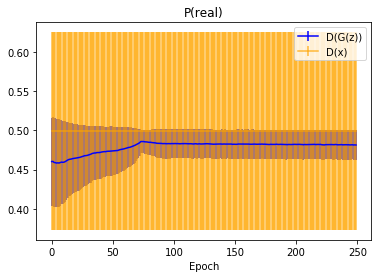

..................................................

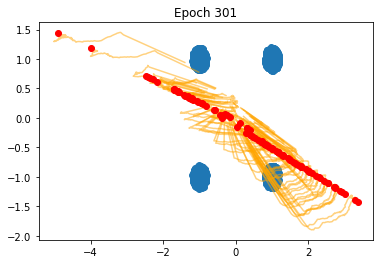

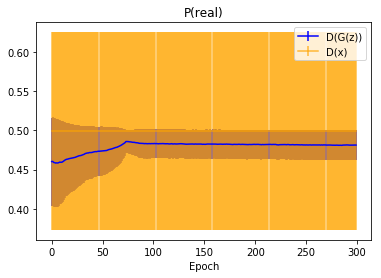

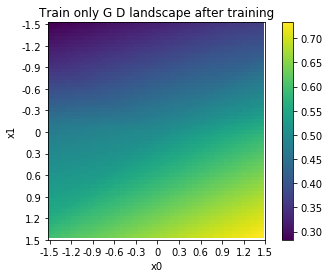

Train only D


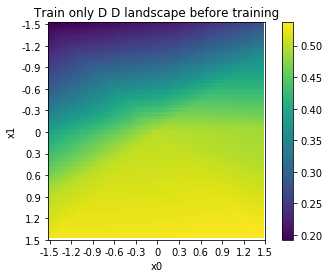

..................................................

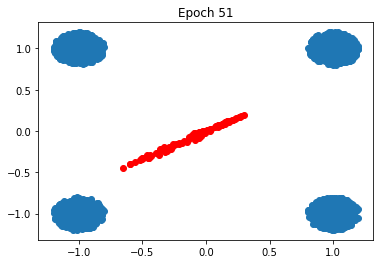

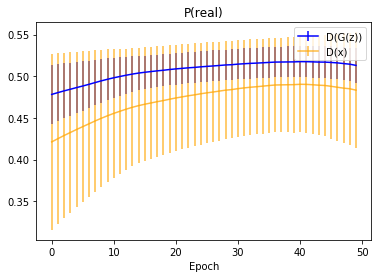

..................................................

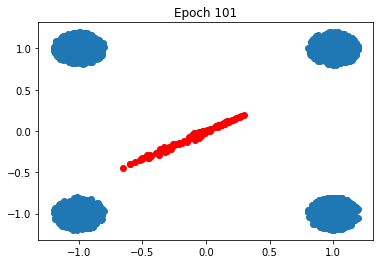

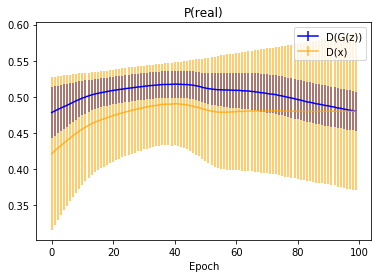

..................................................

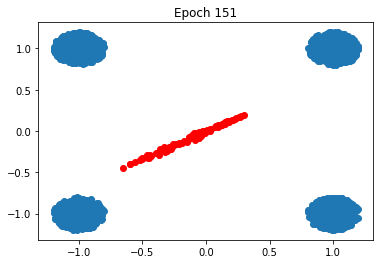

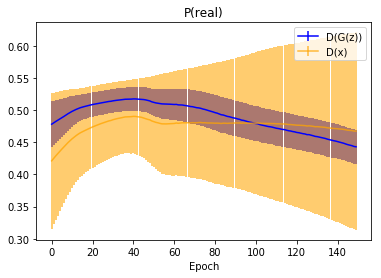

..................................................

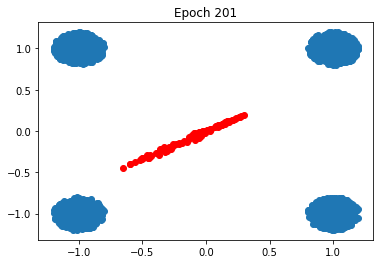

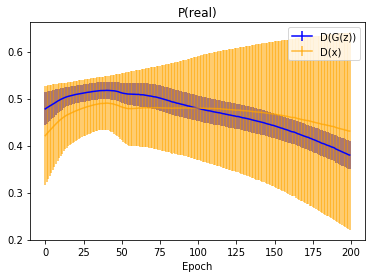

..................................................

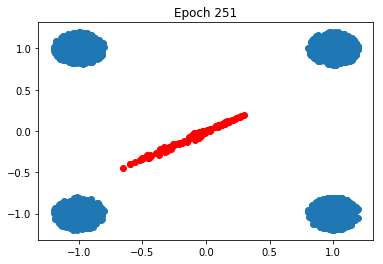

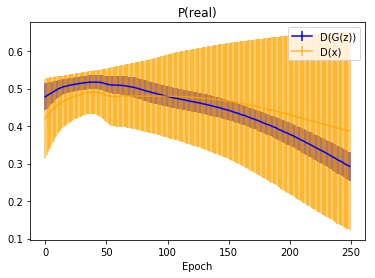

..................................................

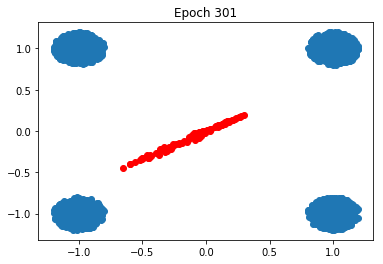

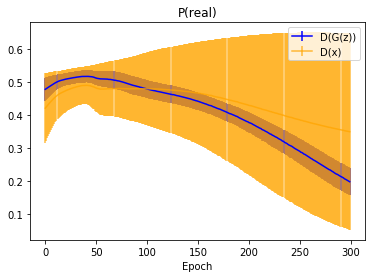

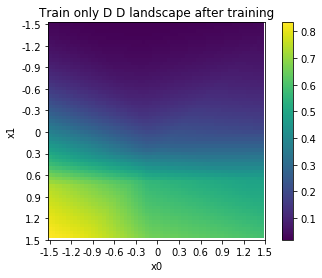

Train G and D


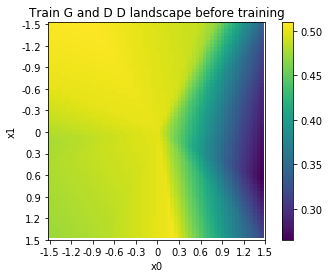

..................................................

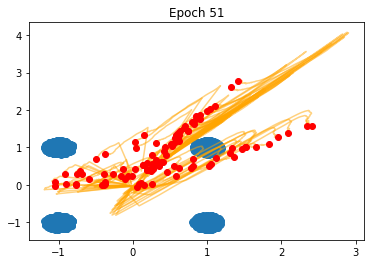

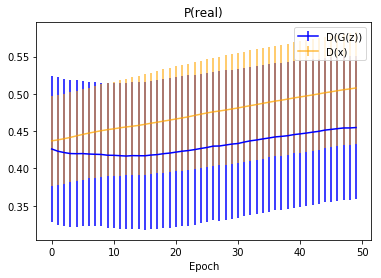

..................................................

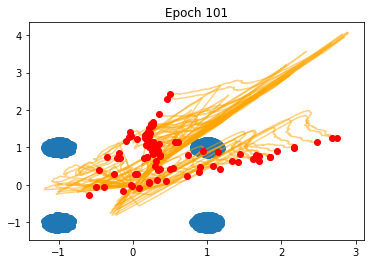

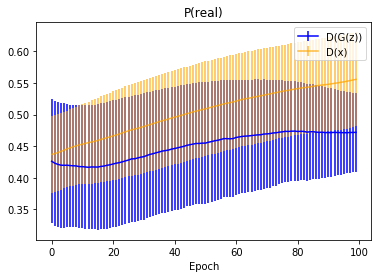

..................................................

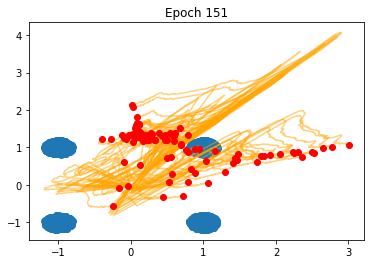

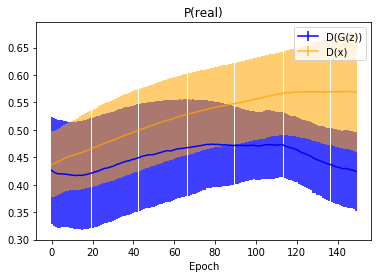

..................................................

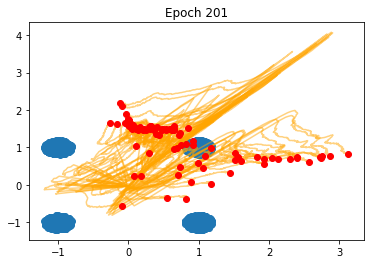

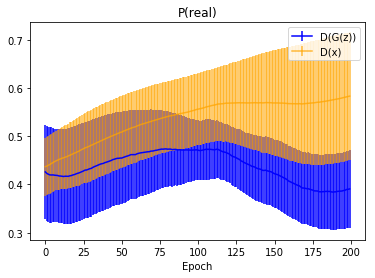

..................................................

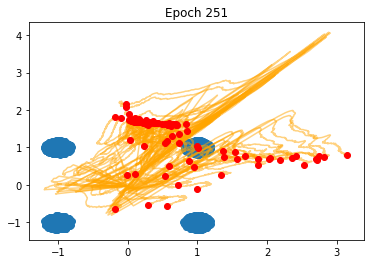

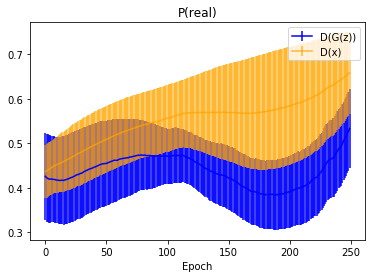

..................................................

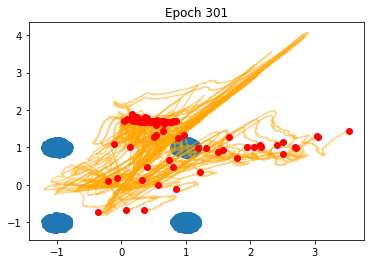

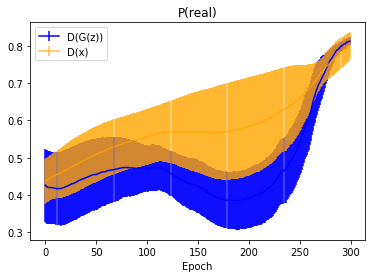

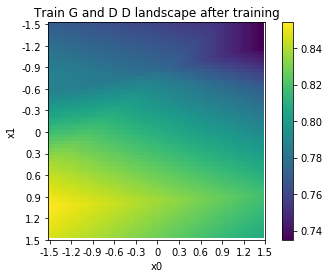

In [58]:
def d_g_ratio_experiment(g_steps, d_steps, experiment_title, arch=mini_arch):
    print("================================================")
    print(experiment_title)
    print("================================================")
    gan = GAN(uniform, Generator(arch), Discriminator(arch))
    score_over_z(lambda x: x, gan.D, title=experiment_title+" D landscape before training")
    
    e = EvolvingCallback(gan)
    m = LossMetrics(gan, x)
    p = PMetrics(gan, x)
    callbacks = [
        (e.track, 1),
        (e.plot, 50),
        (p.track, 1),
        (p.plot, 50)
    ]
    gan.fit(x,
        epochs=300,
        file_prefix='models/2d_uniform',
        callbacks=callbacks,
        d_updates=d_steps,
        g_updates=g_steps
    )
    score_over_z(lambda x: x, gan.D, title=experiment_title+" D landscape after training")

d_g_ratio_experiment(1, 0, "Train only G")
d_g_ratio_experiment(0, 1, "Train only D")
d_g_ratio_experiment(1, 1, "Train G and D")

This doesn't look good at all. We note a few things:
- G is not able to fit D very well if we train only D
- D is not able to fit a randomly initialized fix G and our distribution very well, if we train only D
- If we train both together.

It seems that our mini architecture is not complex enough, but let's also see if D can fit our distribution if we use a generator that just maps the identity.


### Train D with identity G

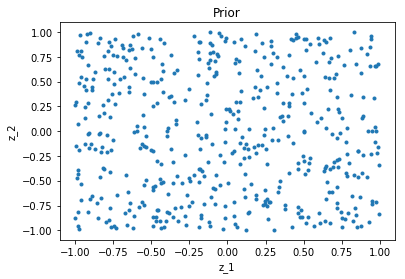

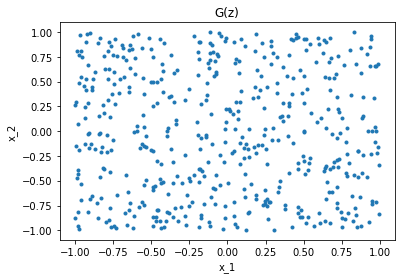

In [44]:
class IdentityG(Generator):
    def __init__(self):
        inputs=keras.Input(shape=[2])
        self.model = Model(inputs=inputs, outputs=self.forward(inputs))
        self.optimizer = keras.optimizers.Adam(0.0002, 0.5)
    
    def forward(self, z):
        return z
    
    def __call__(self, z):
        return z
    
    
show_learned_distribution(uniform,  IdentityG())

..........

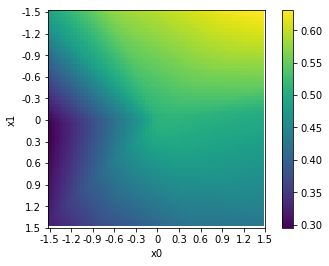

..........

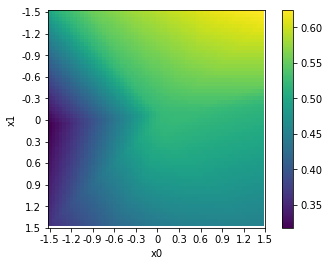

..........

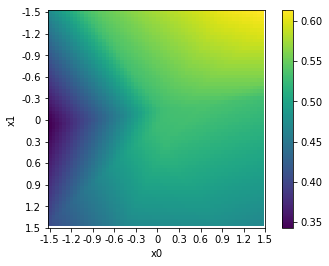

..........

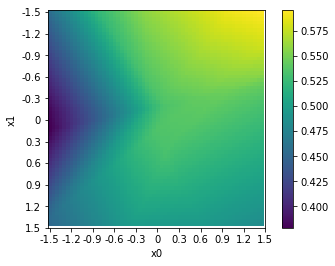

..........

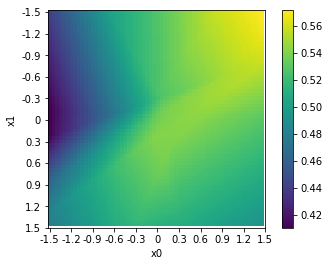

..........

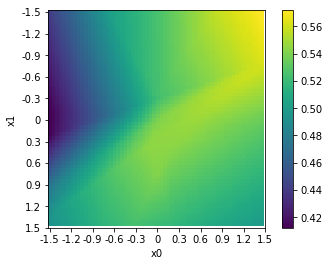

..........

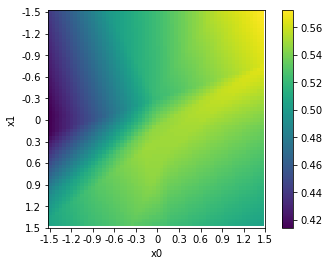

..........

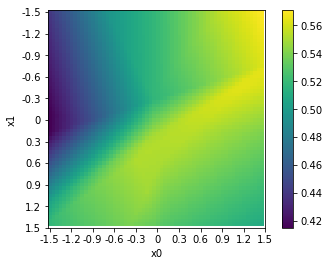

..........

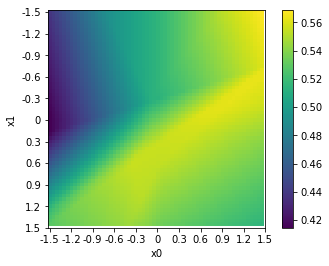

..........

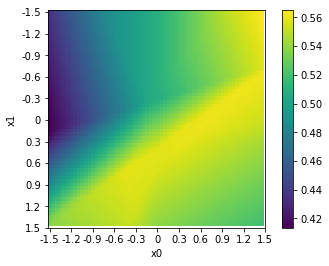

In [57]:
gan = GAN(uniform, IdentityG(), Discriminator(mini_arch))
   

callbacks = [
    (DLandscapeCallback(gan).plot, 10)
]
gan.fit(x,
    epochs=100,
    file_prefix='models/2d_uniform',
    callbacks=callbacks,
    d_updates=1,
    g_updates=0
)

It seems that this net is as dumb as if it had only 8 neurons. It actually has, let's try the bigger architecture.

### Larger Discriminator on uniform G

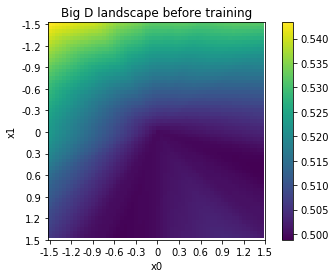

..........

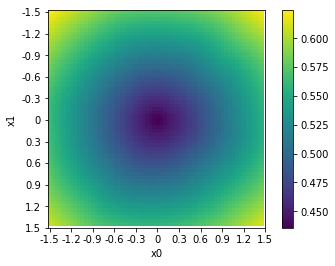

In [79]:
gan = GAN(uniform, IdentityG(), Discriminator(flexibel_arch(512)))
   
score_over_z(lambda x: x, gan.D, title="Big D landscape before training")

callbacks = [
    (DLandscapeCallback(gan).plot, 10)
]
gan.fit(x,
    epochs=10,
    file_prefix='models/2d_uniform',
    callbacks=callbacks,
    d_updates=1,
    g_updates=0
)

We also know the optimal classifier and compare against it:

In [75]:
def optimal_d_for_uniform_fakes(x):
    y = np.zeros(len(x))
    for c in [[-1, -1], [-1, 1], [1, -1], [1, 1]]:
        y[np.linalg.norm(x-np.array([c]), axis=1)<0.2] = 1
    y *= 0.5/y.mean()
    return y

def evaluate_d_on_uniform(d, real):
    fake = np.random.uniform(low=real.min(), high=real.max(), size=real.shape)
    x = np.concatenate([real, fake], axis=0)
    y_pred = d(x)
    y_opti = optimal_d_for_uniform_fakes(x)
    print(f"D: avg real={y_pred[:len(fake)].mean():.2f}\n       fake=={y_pred[len(fake):].mean():.2f}")
    print(f"Opti   real={y_opti[:len(fake)].mean():.2f}\n       fake=={y_opti[len(fake):].mean():.2f}")

evaluate_d_on_uniform(gan.D, x)

D: avg real=0.55
       fake==0.50
Opti   real=0.92
       fake==0.08


Our discriminator really doesn't learn enough. Let's see if it's due to the model capacity or if there is a bug in the train code.

D still does not learn to make D(fakes) small and D(real) large. Super weird, let's make it even simpler and create to non overlapping blops A and B and train to predict P(point belongs to A).

### Train D on even simpler classification task

Let's recreate the classification task from scratch and see if D is now trainable. If it works, the GAN training code is wrong.

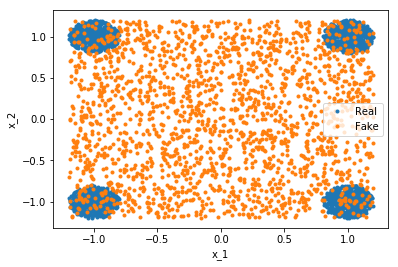

Epoch 1/1
4000/4000 [==============================] - 8s 2ms/step - loss: 0.3868
D: avg real=0.92
       fake==0.31
Opti   real=0.93
       fake==0.07


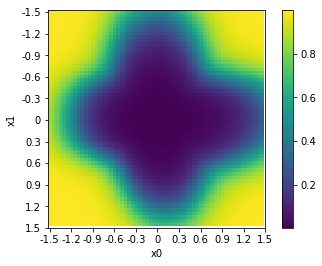

In [87]:
def d_test(a, b):
    show_2d(a, b)

    ab = np.concatenate([a, b], axis=0)
    ab_label = np.zeros(len(a)+len(b))
    ab_label[:len(a)] = 1
    
    d = Discriminator(flexibel_arch(512))
    d_loss = keras.losses.binary_crossentropy
    d.model.compile(d.optimizer, d_loss)
    d.model.fit(ab, ab_label)
    evaluate_d_on_uniform(d.model.predict, real)
    return d
    
real = x
fake = np.random.uniform(low=x.min(), high=x.max(), size=x.shape)

d = d_test(real, fake)
d_landscape(d)

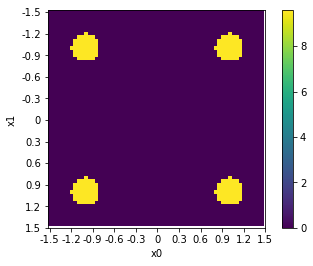

In [88]:
d_landscape(optimal_d_for_uniform_fakes)

D is still not close to the optimum, but orders of magnitudes better. The learning problems should be identical, so it's time to check the GAN training code.

### Initial experiments with larger netwroks

This still doesn't look like the true distribution, but it's much closer. So let's repeat the first experiment with the bigger architecture.

Train only G


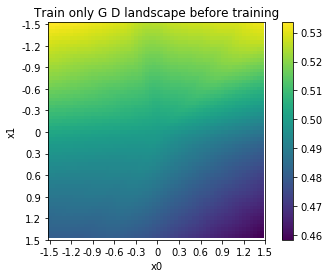

..................................................

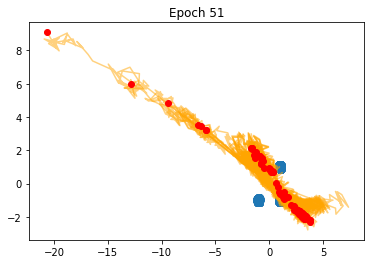

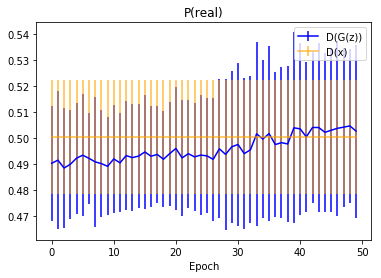

..................................................

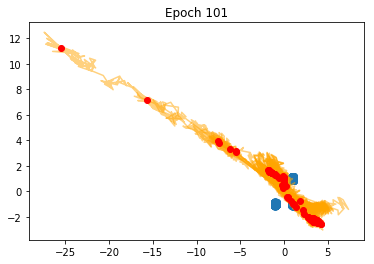

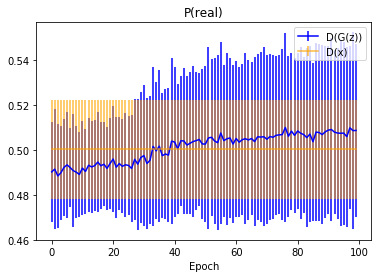

..................................................

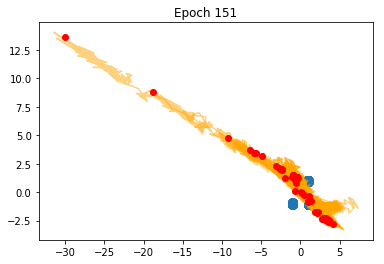

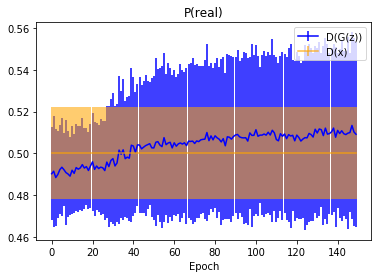

..................................................

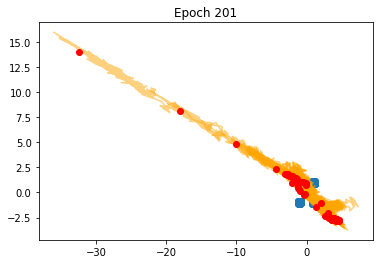

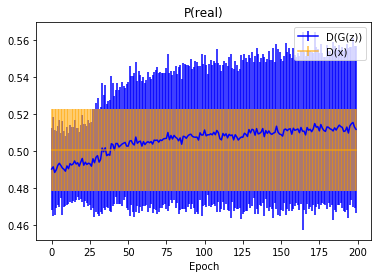

..................................................

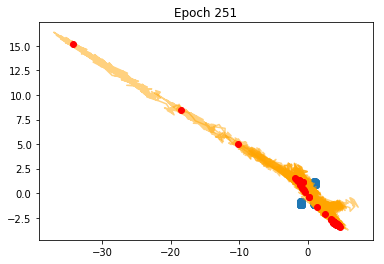

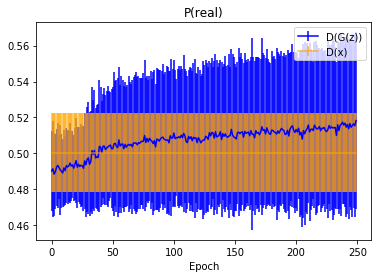

..................................................

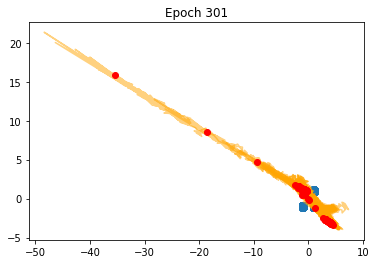

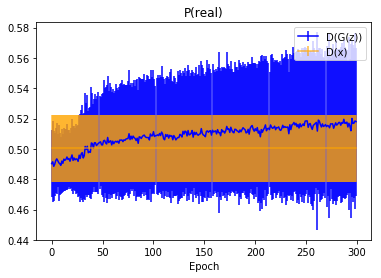

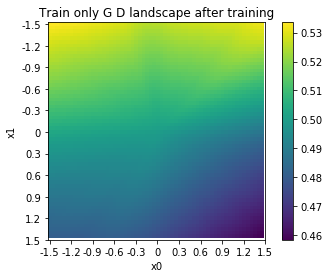

Train only D


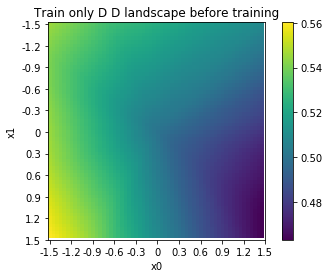

..................................................

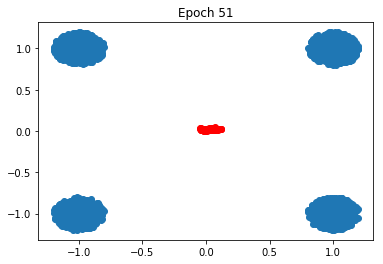

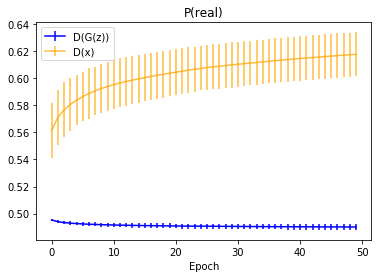

..................................................

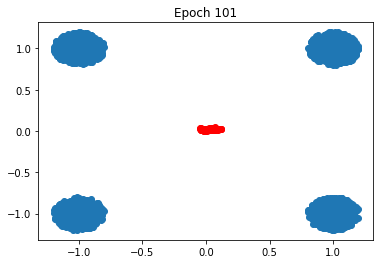

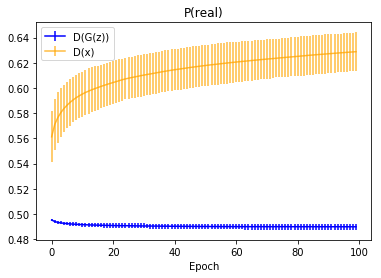

..................................................

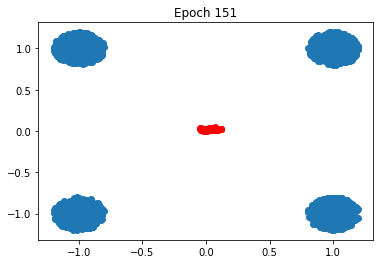

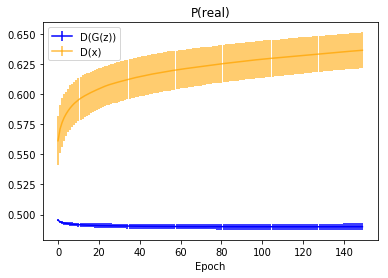

..................................................

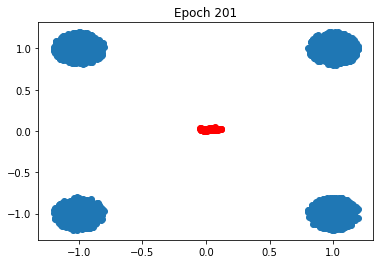

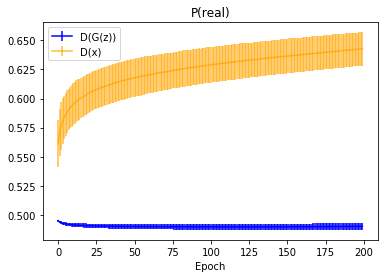

..................................................

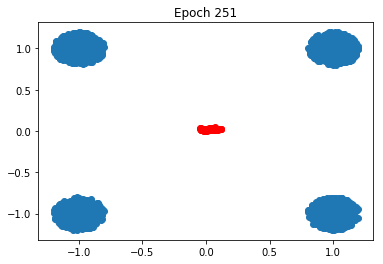

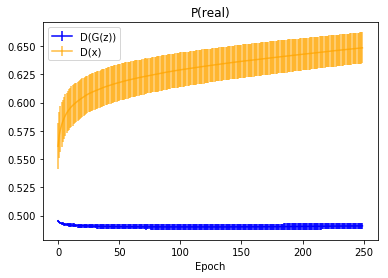

..................................................

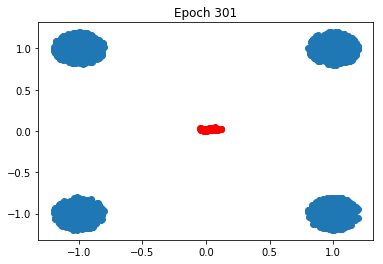

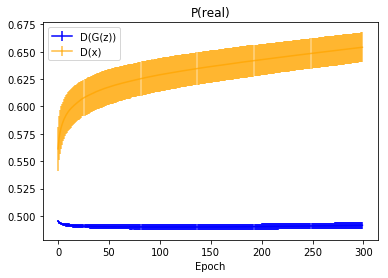

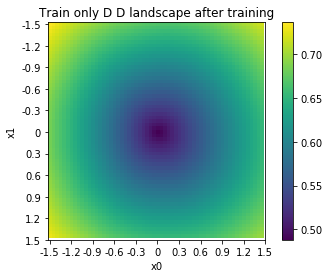

Train G and D


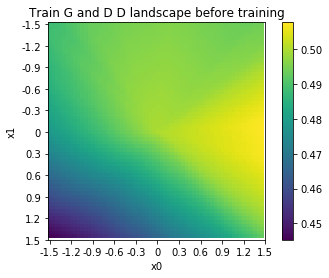

..................................................

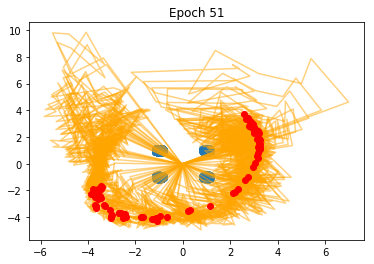

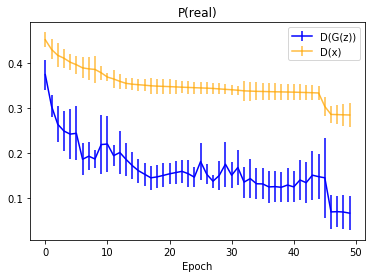

..................................................

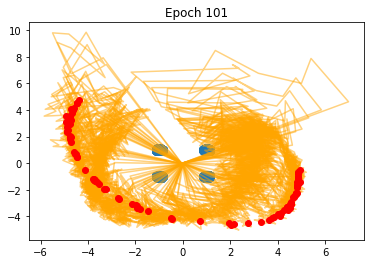

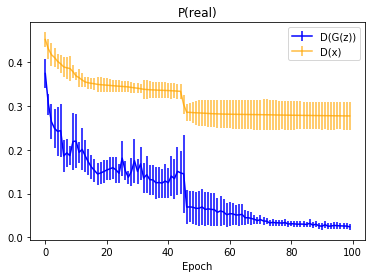

..................................................

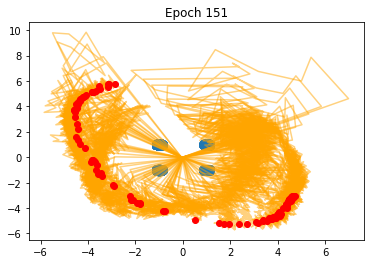

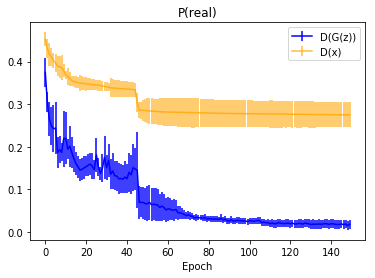

..................................................

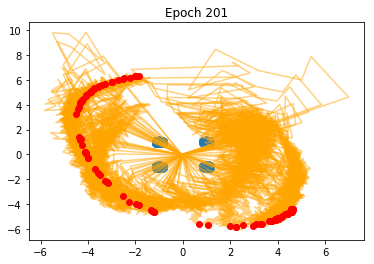

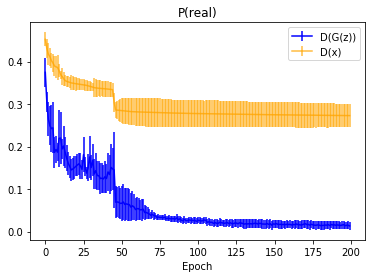

..................................................

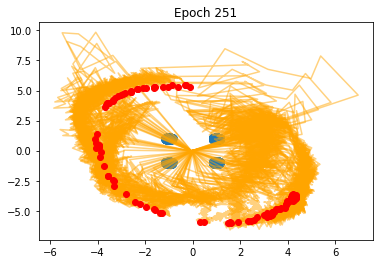

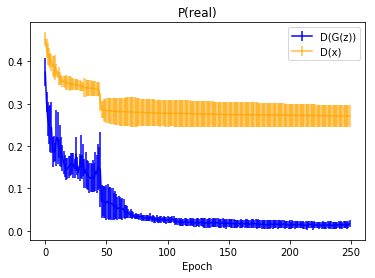

..................................................

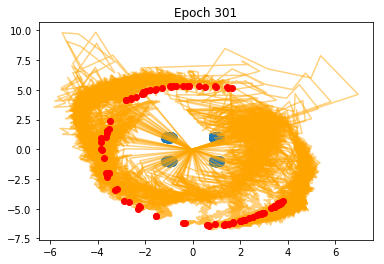

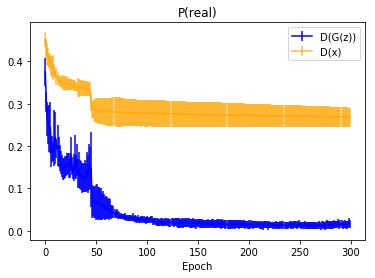

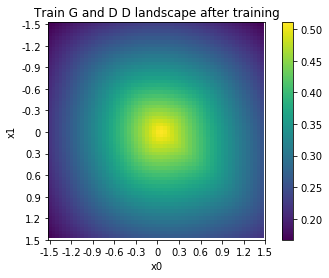

In [59]:
d_g_ratio_experiment(1, 0, "Train only G", flexibel_arch(512))
d_g_ratio_experiment(0, 1, "Train only D", flexibel_arch(512))
d_g_ratio_experiment(1, 1, "Train G and D", flexibel_arch(512))